### Importing libraries

In [26]:
import torchvision.datasets as datasets
from bit_config import *
from utils import *
import torch
from torchsummary import summary
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os, time

model = resmlp_24(pretrained=True)
qmodel = q_resmlp24(model, full_precision_flag=True)

### Tensor shape test

In [66]:
T1 = torch.tensor([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])

torch.abs(T1).max(axis = 0)[0]   

Parameter containing:
tensor([[        inf,  7.4909e-02,  1.4687e-02,  ...,  4.0933e-06,
          2.8284e-05, -4.8382e-05],
        [        inf,  3.3500e-01,  3.2972e-02,  ..., -5.2869e-06,
         -1.0865e-05, -4.0977e-05],
        [        inf,  8.2021e-02,  1.6123e-01,  ..., -5.2562e-06,
          2.2733e-05, -3.1495e-05],
        ...,
        [        inf, -1.1114e-03, -4.9244e-03,  ...,  1.7203e-03,
          3.9699e-04,  2.0260e-04],
        [       -inf,  6.6106e-04,  5.2645e-03,  ...,  4.0270e-04,
          1.7230e-03,  4.6971e-04],
        [       -inf,  2.1209e-03,  2.1342e-03,  ...,  1.0961e-04,
          3.9737e-04,  1.7971e-03]], requires_grad=True)

### Weight/Bias Modification Test

In [2]:
def get_linear_layers(model):
    linear_layers = []
    for name, module in model.named_modules():
        if isinstance(module, QuantLinear):
            linear_layers.append((name, module))
    return linear_layers

# get_linear_layers(qmodel.layer0)[0]

In [37]:
x = torch.randn(5, 384, 196)
b_std_mean = torch.std_mean(x, dim=[0, 1], unbiased=False)
print(x.shape, b_std_mean[0].shape)

torch.Size([5, 384, 196]) torch.Size([196])


In [3]:
def cross_layer_equalization(linear_layers):
    '''
    Perform Cross Layer Scaling :
    Iterate modules until scale value is converged up to 1e-8 magnitude
    '''
    S_history = dict()
    eps = 1e-8
    converged = [False] * (len(linear_layers)-1)
    with torch.no_grad(): 
        while not np.all(converged):
            for idx in range(1, len(linear_layers)):
                (prev_name, prev), (curr_name, curr) = linear_layers[idx-1], linear_layers[idx]
                
                range_1 = 2.*torch.abs(prev.linear.weight).max(axis = 1)[0] # abs max of each row * 2
                range_2 = 2.*torch.abs(curr.linear.weight).max(axis = 0)[0] # abs max of each col * 2
                S = torch.sqrt(range_1 * range_2) / range_2

                if idx in S_history:
                    prev_s = S_history[idx]
                    if torch.allclose(S, prev_s, atol=eps):
                        converged[idx-1] = True
                        continue
                    else:
                        converged[idx-1] = False

                # div S for each row
                prev.linear.weight.data.div_(S.view(-1, 1))
                if prev.linear.bias is not None:
                    prev.linear.bias.data.div_(S)
                
                # mul S for each col
                curr.linear.weight.data.mul_(S)
                    
                S_history[idx] = S
    return linear_layers

def cle_for_resmlp(model):
    for i in range(0, 24):
        todo_layer = getattr(model, f'layer{i}')
        linear_layers = get_linear_layers(todo_layer)[3:] # cross-channel sublayer only
        cross_layer_equalization(linear_layers)



In [60]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def calibrate(val_loader, model):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time],
        prefix='Calibrate: ')

    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.cuda()
            target = target.cuda()

            # compute output
            output = model(images)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 10 == 0:
                progress.display(i)

    print('Calibration done.')

def find_layers_dist(linear_layers):
    layers_dist = {}
    momentum = 0.1
    def get_std_mean(name):
        def hook(model, input, output):
            new_std_mean = output.detach().torch.std_mean(x, dim=[0, 1], unbiased=False)
            if name in layers_dist:
                layers_dist[name][0] = (layers_dist[name][0]*momentum) + (new_std_mean[0]*(1 - momentum))
                layers_dist[name][1] = (layers_dist[name][1]*momentum) + (new_std_mean[1]*(1 - momentum))
            else:
                layers_dist[name] = new_std_mean
        return hook

    # register hook
    for i, (n, m) in enumerate(linear_layers):
        m.register_forward_hook(get_std_mean(f'l{i}-{n}'))

    # access small batch of validation data
    data_loc = "/mnt/disk1/imagenet"
    valdir = os.path.join(data_loc, 'val')
    train_resolution = 224
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    val_dataset = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.RandomResizedCrop(train_resolution),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    
    data_percentage = 0.0001
    dataset_length = int(len(val_dataset) * data_percentage)
    partial_train_dataset, _ = torch.utils.data.random_split(val_dataset,
                                                                [dataset_length, len(val_dataset) - dataset_length])
    val_loader = torch.utils.data.DataLoader(
        partial_train_dataset, batch_size=32, shuffle=True,
        num_workers=4, pin_memory=True, sampler=None)

    calibrate(val_loader, model)

    return layers_dist
    

def high_bias_absorption(linear_layers, layers_dist):
    for idx in range(1, len(linear_layers)):
        (prev_name, prev), (curr_name, curr) = linear_layers[idx-1], linear_layers[idx]
        gamma, beta = layers_dist[idx-1]
        # torch.std_mean(a, dim=1, unbiased=False)[0]

def resmlp_bias_absorb(model):
    linear_layers = []
    for i in range(0, 24):
        todo_layer = getattr(model, f'layer{i}')
        linear_layers += get_linear_layers(todo_layer)[3:] # cross-channel sublayer only
    print(len(linear_layers))
    layers_dist = find_layers_dist(linear_layers)
    high_bias_absorption(linear_layers, layers_dist)

resmlp_bias_absorb(qmodel)
# getattr(qmodel, f'layer0')

96


FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: '/mnt/disk1/imagenet\\val'

### Weight/Bias Distribution Test

In [4]:
def weight_dist_layer(model, start, end):
  plt.title('Weight Distribution of Each Layer')
  plt.rcParams["figure.figsize"] = [20, 5]
  plt.rcParams["figure.autolayout"] = True

  data = []
  labels = []
  for i in range(start, end+1):
    todo_layer = getattr(model, f'layer{i}')
    tlist = get_linear_layers(todo_layer)

    for j, (n, m) in enumerate(tlist):
      val = m.linear.weight.detach().numpy().flatten()
      data.append(val)
      labels.append(f'{i}')
    
  # Creating plot
  bp = plt.boxplot(data, labels=labels)
  plt.show()

def bias_dist_layer(model, start, end):
  plt.title('Bias Distribution of Each Layer')
  plt.rcParams["figure.figsize"] = [20, 5]
  plt.rcParams["figure.autolayout"] = True

  data = []
  labels = []
  for i in range(start, end+1):
    todo_layer = getattr(model, f'layer{i}')
    tlist = get_linear_layers(todo_layer)

    for j, (n, m) in enumerate(tlist):
      if m.linear.bias is not None:
        val = m.linear.bias.detach().numpy().flatten()
        data.append(val)
        labels.append(f'{i}')
    
  # Creating plot
  bp = plt.boxplot(data, labels=labels)
  plt.show()

def weight_dist_gamma(model, start, end):
  plt.title('Weight Distribution of Gamma_1/Gamma_2 for Each Layer')
  plt.rcParams["figure.figsize"] = [20, 5]
  plt.rcParams["figure.autolayout"] = True

  data = []
  labels = []
  mdict = model.state_dict()
  for i in range(start, end+1):
    layer1_name = f'layer{i}.gamma_1.linear.weight'
    data1 = mdict[layer1_name].detach().numpy().flatten()

    layer2_name = f'layer{i}.gamma_2.linear.weight'
    data2 = mdict[layer2_name].detach().numpy().flatten()

    # data = np.concatenate([[data1], [data2]], axis=0)
    data.append(data1)
    data.append(data2)
    labels.append(f'{i}g1')
    labels.append(f'{i}g2')
    
  # Creating plot
  bp = plt.boxplot(data, labels=labels)
  plt.show()

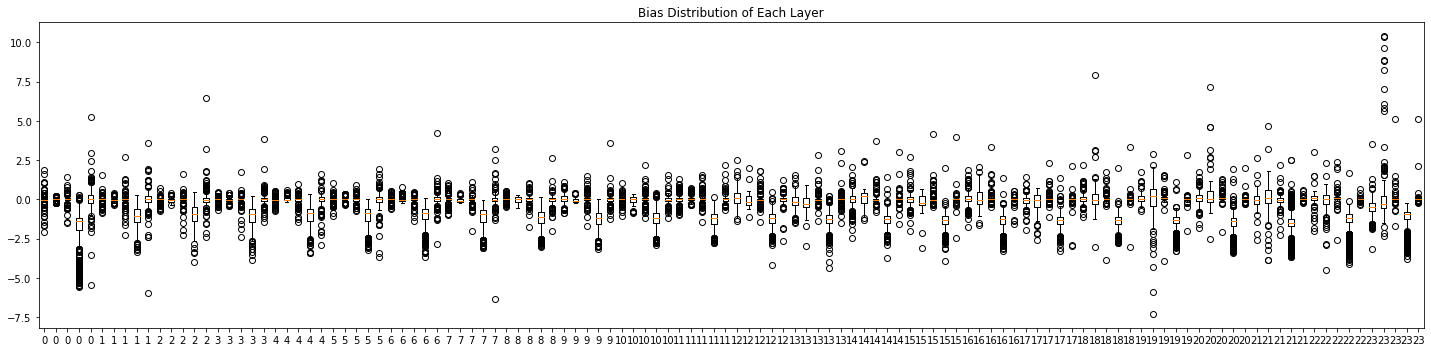

In [8]:
model = resmlp_24(pretrained=True)
qmodel = q_resmlp24(model, full_precision_flag=True)
bias_dist_layer(qmodel, 0, 23)

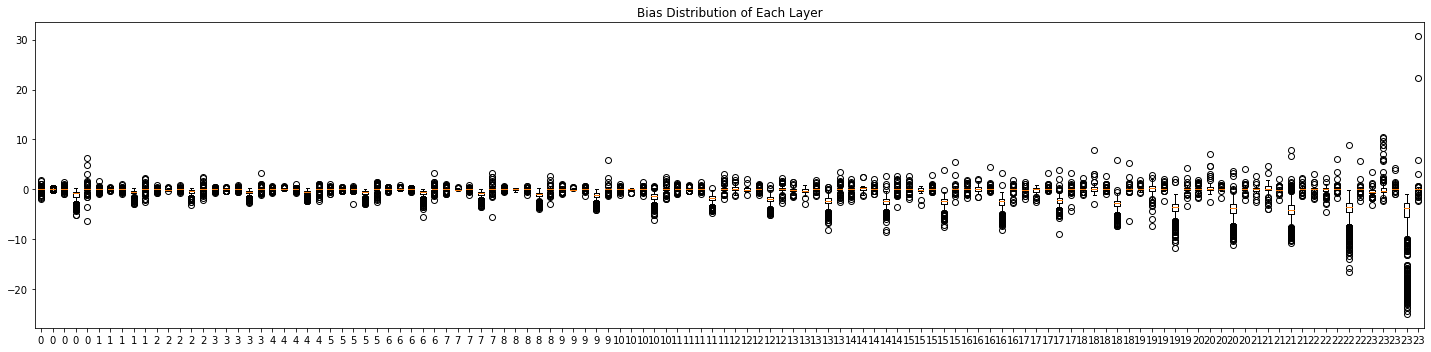

In [7]:
cle_for_resmlp(qmodel)
bias_dist_layer(qmodel, 0, 23)
# weight_dist_gamma(qmodel, 0, 23)

In [ ]:
# plt.rcParams["figure.figsize"] = [20, 5]

# plt.rcParams["figure.autolayout"] = True

# layer_name = 'layer0.gamma_2.weight'
# print("(min, max):  ", (qmdict[layer_name].min(), qmdict[layer_name].max()))
# print("(std, mean): ", torch.std_mean(qmdict[layer_name], unbiased=False))
# ax = sns.heatmap(qmdict[layer_name])
# ax.plot()

# layer_name = 'layer1.gamma_1.weight'
# print("(min, max):  ", (qmdict[layer_name].min(), qmdict[layer_name].max()))
# print("(std, mean): ", torch.std_mean(qmdict[layer_name], unbiased=False))
# ax = sns.heatmap(qmdict[layer_name])
# ax.plot()

### Activation Distribution Test

In [71]:
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_resolution = 224  
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(train_resolution),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

# simulate input
x = np.array(np.rint(np.random.rand(500, 375, 3) * 255), dtype=np.uint8)
x = transform(x).unsqueeze(0)
# cuda0 = torch.device('cuda:0')
# x = x.to(cuda0)

In [212]:
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output[0].detach()
    return hook

getattr(qmodel, 'quant_patch').norm.register_forward_hook(get_activation('in'))
for i in range(0, 24):
  layer_name = f'layer{i}'
  layer1_name = f'{i}g1'
  layer2_name = f'{i}g2'
  getattr(qmodel, layer_name).gamma_1.register_forward_hook(get_activation(layer1_name))
  getattr(qmodel, layer_name).gamma_2.register_forward_hook(get_activation(layer2_name))

output = qmodel(x)

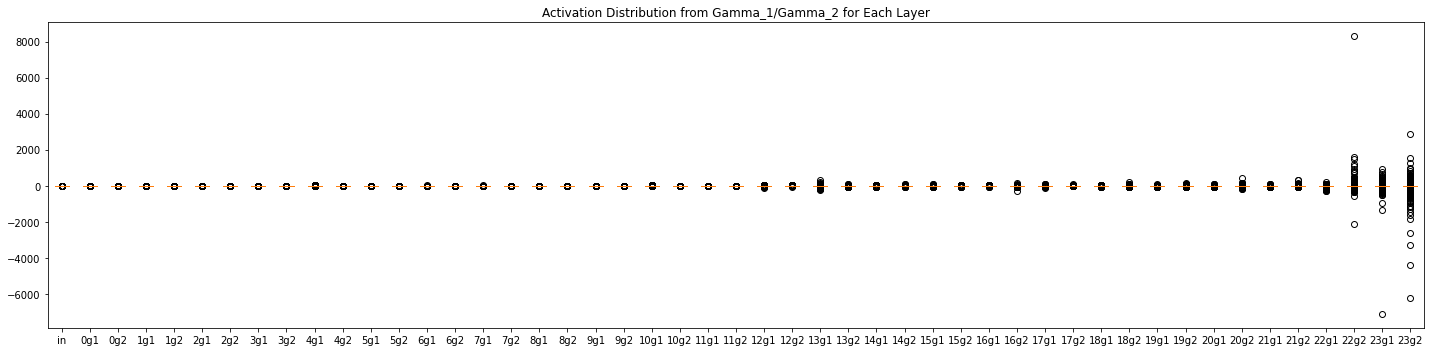

In [213]:
plt.title('Activation Distribution from Gamma_1/Gamma_2 for Each Layer')
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams["figure.autolayout"] = True

data = []
labels = []

from_layers=0
to_layers=24
for name in list(activations)[from_layers*2 : to_layers*2+1]:
  labels.append(name)
  # print(activations[name].shape)
  data.append(activations[name][0].flatten())
  
# Creating plot
bp = plt.boxplot(data, labels=labels)
plt.show()

### QAT weight comparison test

In [72]:
# for a in qmodel.named_modules():
#   print(a)

In [208]:
import torch.nn as nn
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.my_tensor = torch.zeros(1) # 参数直接作为模型类成员变量
    self.register_buffer('my_buffer', torch.zeros(1)) # 参数注册为 buffer
    self.my_param = nn.Parameter(torch.zeros(1), requires_grad=False)

  def forward(self):
    self.my_tensor = torch.ones(1)
    self.my_param = nn.Parameter(torch.ones(1), requires_grad=False)
    self.my_buffer = torch.ones(1)
    return

model = MyModel()
model()

print(model.state_dict())
model.cuda()
print(model.state_dict())

OrderedDict([('my_param', tensor([1.])), ('my_buffer', tensor([1.]))])
OrderedDict([('my_param', tensor([1.], device='cuda:0')), ('my_buffer', tensor([1.], device='cuda:0'))])


In [36]:
checkpoint = torch.load("model_best.pth.tar")['state_dict']
# print(checkpoint)
modified_dict = {}
for key, value in checkpoint.items():
    if 'num_batches_tracked' in key: continue
    # if 'weight_integer' in key: continue
    # if 'bias_integer' in key: continue

    modified_key = key.replace("module.", "")
    modified_dict[modified_key] = value
qmodel.load_state_dict(modified_dict, strict=True)

<All keys matched successfully>

In [44]:
org_model = resmlp_24(pretrained=True)
org_qmodel = q_resmlp24(org_model, full_precision_flag=True)

torch.equal(qmodel.layer0.gamma_1.linear.weight, org_qmodel.layer0.gamma_1.linear.weight)